Okay, this is getting to the pointy end a bit. In this notebook we take our grids that we made in notebook 6 (6_GMT_processing) and use them, along with the plate boundaries of the plate model to get the intersection with subduction zones and from that, the subduction flux of serpentinite and/or carbonate (or any other variable one desires). We have, of course, two different models (using plate model spreading rates or Pacific Ocean spreading rates) as well as three different ways of measuring uncertainty (see notebook 3); full, batch or individual. We prefer to use 'batch' uncertainty, as it plays a midpoint between full and individual, thus accommodating the inherent uncertainty in spreading rates in the plate model. For serpentinite it is recommended not use 'full' as the bimodal distribution will produce a very (very) large error bar.

Futhermore, there is a separate conceptual issue, especially with using the POSR vs PMSR models, and in the  implementation in the paper.

- In original publication POSR used vertical area (i.e. distance between two hypothetical isochrons) for times prior to 160 Ma in order to deail with uncertainty in ocean basin reconstructions. We also did this with the PMSR values to be consistent.
- This causes a problem though, because when we go to sub flux we use the passed in spreading rate instead of the convergence rate to determine the third dimension of our flux (along with thickness and subduction segment length). E.g. vertical area approach: flux = thickness • spreading rate at point creation • length of subduction zone. vs. thickness • local convergence rate • length of subduction zone
- This means crust formed at slow spreading ridges (i.e. high serpentinite) but subdcuted at times of fast convergence (i.e. late Cretaceous) are likely to underestimate the amount of serpentinite (and the converse is true). This is probably not so important for carbon, as inorganic carbon is stored to a similar order of magnitude irrispective of MOR dynamics.
- In the publication we tried to minimise this be weighting these cases by multiplying the flux by the local convergence rate-to-global mean convergence rate ratio (that later of which is ~65 mm/a). This should have the effect of increasing the estimates during times of high convergence rate in the plate model and lowering the estimates during times of low convergence rates.
- There are two problems though that we did not consider at the time, and now I think are important to address:
    1) Serpentinite has a bimodal disrtibution and forms preferentially at slow ridges, therefore it should be divided by a value closer to ~20 mm/a (here we opt for 17 mm/a as the average spreading rate of ridges spreading more slowly than 40 mm/a) to reflect this, rather than 65 mm/a
    2) For times after 160 Ma (when we have a good seafloor spreading record) we still used the vertical area. In these cases we should be using the local convergence rate from the plate model instead of vertical area, as ther e is a seafloor spreading history. This means we have to divide these values by the spreading rate at creation to go back to point thickness, then use local convergence rate.

In the future I think the best approach will be to somehow use the spreading rate at time X (for pre 160 Ma) as a proxy for convergence rate also at time X, of the great circle drawn between the mid ocean ridge segment and the subduction zone. Or perhaps sampling the Pacific spreading distribution for convergence rate as well. But I'm not quite sure if the current framework would support that super well.

Implementing these changes leads to a revision, in particular, in the Cretaceous of serpentinite subduction flux. This is partly because in the plate model the pacific is slowly spreading between 170 and 140 Ma, then very quickly spreading between 140 and 100 Ma.


In [5]:
import numpy as np
import pygplates
import pandas as pd
import time as tme
import math
import subduction_convergence
import serpentinites_distributions
import raster_query
import pickle
import csv

In [6]:
#set base directories
datadir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/'
loaddir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/results/'

rotation_filename = '%sMatthews_etal_GPC_2016_410-0Ma_GK07.rot' % datadir
topology_dir = datadir
thickness_grid_dir = loaddir + 'rasters'
#some variables
tessellation_threshold_radians = math.radians(0.5)
search_radius_radians = math.radians(20.0)
smoothing_radius_radians = None

#density carbon g/cm3
carbon_density = 2.26
carbon_densitygkm3 = float(carbon_density * 100000**3)
carbon_densitygm3 = float(carbon_density *100**3)

#density serpentinites g/cm3
serpentinites_density = 3.00 #ranges between 2.7-3.3
serpentinites_densitghhygkm3 = float(serpentinites_density * 100000**3)
serpentinites_densitygm3 = float(serpentinites_density *100**3)

In [3]:
def running_mean(x, N, mode):
    
    '''
    uses np.convolve to return a running mean.
    X: 1D array or list of values to compute running mean
    N: window size of running mean
    mode: valid, full or same (see https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    for an example of the difference). I default to 'valid'.
    '''
    #x = np.pad(x, (0, N // 2), mode='constant', constant_values = np.nan)
    return np.convolve(x, np.ones((N,))/N, mode=mode)

In [42]:
def get_distribution(variable, method):
    
    '''
    Accesses a pickle file made in '3_Uncertainty_Distributions_per_spreading_rate' which stores a
    distribution of expected variable values at different spreading rates. Three approaches depenting on 'method'.

    Variable (String): What variable (e.g. Carbon, serpentinite) distirbution we want access to.
    Method (String): What distribution method we want to access; (1) individual; (2) batch; (3) full
    
    1) Distribution for each spreading rate is recovered and sampled to perturb
    2) Distirbution for each spreading rate classificaiton is recovered and sampled to perturb
    3) Full distribution for all spreading rates are recovered
    '''
    
    if variable == 'Gabbro' and method =='full':
        with open('%sGabbro_thickness_slow_full.pkl' % (loaddir), 'rb') as f:
            first = pickle.load(f)
        with open('%svolcanics_thickness_full.pkl' % (loaddir), 'rb') as f:
            distribution = np.vstack((first, pickle.load(f)))
    else:
            
        with open('%s%s_thickness_%s.pkl' % (loaddir, variable, method), 'rb') as f:
            distribution = pickle.load(f)
        
    
        
    return distribution

In [45]:
get_distribution('Gabbro', 'full')[0][0]

1.4429628749027286

In [51]:
def calc_subducting_sediment_volume(time, 
                                    samples, 
                                    variable,
                                    distribution,
                                    thickness_threshold, 
                                    uncertainty_method, 
                                    PMSR=True):
    
    '''
    Variable (string): What variable (e.g. Carbon, serpentinite) we are calculating.
    Thickness_threshold (float): Only used for POSR, to undo some large vales that flag whether a point was made
    under POSR or PMSR.
    Uncertainty_method (string): What distribution method we want to access; (1) individual; (2) batch; (3) full
    PMSR: True for PMSR, or False for POSR
    '''
    
    if PMSR:
        key='PMSR'
    
    else:
        key='POSR'
    print (key)

    #to normalise values against convergence rate if POSR
    mean_spreading_rate = 64.96
    mean_spreading_rate_serp = 17.3
    
    #load topologies and thicknesses
    rotation_model = pygplates.RotationModel(rotation_filename)
    topology_features = pygplates.FeaturesFunctionArgument(
            (topology_dir + 'Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz',
            topology_dir +  'Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')).get_features()
    spreading_grid_filename = thickness_grid_dir + '/{}_SR_{}_Ma.grd'.format(key, time)
    thickness_grid_filename = thickness_grid_dir + '/{}_{}_{}_Ma.grd'.format(key, variable, time)

    #get subduction data
    subduction_convergence_data = subduction_convergence.subduction_convergence(
                rotation_model,
                topology_features,
                tessellation_threshold_radians,
                time)
    subduction_points = [pygplates.PointOnSphere(data[1], data[0]) for data in subduction_convergence_data]
    
    #We want the spreading rate of each point when it was created
    spreading_rate_at_points_creation = raster_query.query_raster_at_points(
                                                        spreading_grid_filename,
                                                        subduction_points,
                                                        search_radius_radians,
                                                        smoothing_radius_radians)
    #
    #Sample the thickness raster at the subduction points.      
    variable_thicknesses = raster_query.query_raster_at_points(
            thickness_grid_filename,
            subduction_points,
            search_radius_radians,
            smoothing_radius_radians)

    
    # Iterate over subduction points/thicknesses and calculate statistics (including subducting volume).
    #we want it per in km3 per Ma
    total_subducting_length_kilometres = np.zeros([samples])
    total_subducting_volume_km_3_per_Ma = np.zeros([samples])

    for subduction_point_index, thickness in enumerate(variable_thicknesses):
        if math.isnan(thickness):
            continue
        
        local_spreading_rate_at_creation = np.round(spreading_rate_at_points_creation[subduction_point_index])
        
        #round up incase
        if local_spreading_rate_at_creation == 0:
            local_spreading_rate_at_creation = 1
        
        if uncertainty_method == 'individual':
            if local_spreading_rate_at_creation > 100:
                local_spreading_rate_at_creation = 100
                
            variable_key = int(local_spreading_rate_at_creation)

            variation = distribution[variable_key-1]
            
        if uncertainty_method == 'batch':
            if local_spreading_rate_at_creation <= 20:
                variable_key = 0
            elif 20 < local_spreading_rate_at_creation <= 40:
                variable_key = 1
            elif 40 < local_spreading_rate_at_creation <= 70:
                variable_key = 2
            else:
                variable_key = 3

            variation = distribution[variable_key]
        
        if uncertainty_method == 'full':
            if variable != 'Gabbro':
                   variation = distribution
            else:
                if local_spreading_rate_at_creation <= 40:
                    variable_key = 0
                else:
                    variable_key = 1
            
                variation = distribution[variable_key]
                                
            
#        print (local_spreading_rate_at_creation)            
        #organise our perturbation to generate uncertainty
        
        #variation = distribution[20]
        mean_variation = np.mean(variation)

        perturbation = variation/mean_variation

        #testing here
        #it might be in the spherical interpolation that value average to include a basaltic component
        #in a slow/ultraslow spreading rate, in which case a '0' value would not fully represent
        #what is preserved. So in this case we just put 1 for now. But to be rectified, as this could be
        #a way to ensure more variability within the final results (i.e. resum the thickness at each point
        #if there's a non gabbroic volcanic component, then that crustal thickness is greater?)
        perturbation[perturbation == 0] = 1

        subduction_convergence_item = subduction_convergence_data[subduction_point_index]
        
        subducting_lon = subduction_convergence_item[0]
        subducting_lat = subduction_convergence_item[1]
        convergence_velocity_magnitude_cm_per_yr = subduction_convergence_item[2]
        convergence_obliquity_degrees = subduction_convergence_item[3]
        subducting_length_degrees = subduction_convergence_item[6]
        
        #eh unit conversions, we want the final result to be in km3/Ma
        subducting_length_kilometres = (
            math.radians(subducting_length_degrees) * pygplates.Earth.mean_radius_in_kms)

        total_subducting_length_kilometres += subducting_length_kilometres
        convergence_normal_velocity_km_per_Ma = (
            # 1e-5 converts cm/y to km/y...
            1e-5 * math.fabs(convergence_velocity_magnitude_cm_per_yr) *
            # Negative convergence handled by cos(obliquity_angle)...
            math.cos(math.radians(convergence_obliquity_degrees)) * 1e6)
        
        #because we don't mask, some points may be warped with spinterpolate to be haflway between small and big 
        #usually on the order of 10^1. in this case we divide by the difference by 1000
        #0.01 and 5 for carbon
        #if np.abs(thickness) > 0.01 and np.abs(thickness) < 5:
        #    prev_ind = subduction_point_index
        #    thickness = thicknesses[subduction_point_index-1]
        
        #if PMSR:
        #    spreading_convergence_ratio = np.nan
        #    subducting_volume_km_3_per_Ma = (
        #        np.abs(thickness) * perturbation *\
        #        subducting_length_kilometres * convergence_normal_velocity_km_per_Ma)

        
        if np.abs(thickness) > thickness_threshold:
            #print('here')
            #we are in POSR territory
            #pass in the appropriate thickness_threshold

#            if np.abs(thickness) > thickness_threshold:
            #undoes our fix to tell crust formed before 160 Ma from ocean crust afterwards
            thickness = thickness * 1e-6

            #spreading convergence ratio
            #limits the [conceptual] effect of POSR where more/less crust is created at a ridge
            #that then what is passed into the equation
            if time > 160:
                spreading_convergence_ratio = convergence_normal_velocity_km_per_Ma/mean_spreading_rate
                
            else:
                spreading_convergence_ratio = convergence_normal_velocity_km_per_Ma/local_spreading_rate_at_creation
                                
            subducting_volume_km_3_per_Ma = (
            np.abs(thickness) * subducting_length_kilometres * spreading_convergence_ratio *perturbation)#
        else:

            subducting_volume_km_3_per_Ma = np.abs(
            thickness * subducting_length_kilometres * convergence_normal_velocity_km_per_Ma * perturbation)#

        total_subducting_volume_km_3_per_Ma += subducting_volume_km_3_per_Ma

    return (total_subducting_volume_km_3_per_Ma)

In [52]:
#just to get what we want for a bigger analysis
samples=10000
max_time = 200
times = np.arange(0, 200+1, 1)
thickness_threshold = 5.0#0.10 #100 m for carbon, 5 km for serp
z = np.zeros([max_time+1, samples])

#change for POSR
variable = 'Serp'
uncertainty_method = 'full' #full, individual or batch
model_type = 'PMSR' #PMSR or POSR
#load our desired distribution *
distribution = get_distribution(variable, uncertainty_method)
for ind,time in enumerate(times):
    start_time = tme.time()
    print(time)
    v = calc_subducting_sediment_volume(time,samples, variable, distribution, thickness_threshold, 
                                        uncertainty_method, PMSR=True)
    z[time,::] = v
    print("--- %s seconds for timestep ---" % (tme.time() - start_time))
    
#with open('%s%s_SUB_%s_%s' % (savedir, variable, model_type, uncertainty_method) + '.csv', 'wb') as f:
#    writer = csv.writer(f)
#    writer.writerows(z)

0
PMSR
--- 13.2229378223 seconds for timestep ---
1
PMSR
--- 14.0883882046 seconds for timestep ---
2
PMSR
--- 14.3459858894 seconds for timestep ---
3
PMSR
--- 14.0020110607 seconds for timestep ---
4
PMSR
--- 14.1204338074 seconds for timestep ---
5
PMSR
--- 14.4676449299 seconds for timestep ---
6
PMSR
--- 14.6273880005 seconds for timestep ---
7
PMSR
--- 13.9714021683 seconds for timestep ---
8
PMSR
--- 15.9279708862 seconds for timestep ---
9
PMSR
--- 13.6000781059 seconds for timestep ---
10
PMSR
--- 13.4682350159 seconds for timestep ---
11
PMSR
--- 13.4221949577 seconds for timestep ---
12
PMSR
--- 13.3017230034 seconds for timestep ---
13
PMSR
--- 12.8240740299 seconds for timestep ---
14
PMSR
--- 13.8626480103 seconds for timestep ---
15
PMSR
--- 15.3435590267 seconds for timestep ---
16
PMSR
--- 15.2046320438 seconds for timestep ---
17
PMSR
--- 16.6584339142 seconds for timestep ---
18
PMSR
--- 13.4443149567 seconds for timestep ---
19
PMSR
--- 13.5647411346 seconds for tim

--- 14.6325900555 seconds for timestep ---
161
PMSR
--- 13.6349189281 seconds for timestep ---
162
PMSR
--- 13.642553091 seconds for timestep ---
163
PMSR
--- 13.946516037 seconds for timestep ---
164
PMSR
--- 14.7693128586 seconds for timestep ---
165
PMSR
--- 16.5829248428 seconds for timestep ---
166
PMSR
--- 16.1091620922 seconds for timestep ---
167
PMSR
--- 15.3774809837 seconds for timestep ---
168
PMSR
--- 15.4636030197 seconds for timestep ---
169
PMSR
--- 15.8021929264 seconds for timestep ---
170
PMSR
--- 16.0158381462 seconds for timestep ---
171
PMSR
--- 15.1937739849 seconds for timestep ---
172
PMSR
--- 15.5598518848 seconds for timestep ---
173
PMSR
--- 16.8141179085 seconds for timestep ---
174
PMSR
--- 17.252478838 seconds for timestep ---
175
PMSR
--- 17.8776090145 seconds for timestep ---
176
PMSR
--- 15.7937650681 seconds for timestep ---
177
PMSR
--- 16.5699410439 seconds for timestep ---
178
PMSR
--- 15.1544601917 seconds for timestep ---
179
PMSR
--- 15.35547089

In [53]:
#quick and dirty plot to make sure it looks somewhat reasonable
import matplotlib.pyplot as plt

#density serpentinites g/cm3
density = 2.26 #serp, 3.0: ranges between 2.7-3.3
densitygkm3 = float(serpentinites_density * 100000**3)
MT_a = densitygkm3/1000/1000000000/1000000

c = z * MT_a

In [54]:
mean = np.asarray([np.mean(i) for i in c])
std = np.asarray([np.std(i) for i in c])

smooth_mean = running_mean(mean, 5, 'valid')
smooth_std = running_mean(std, 5, 'valid')

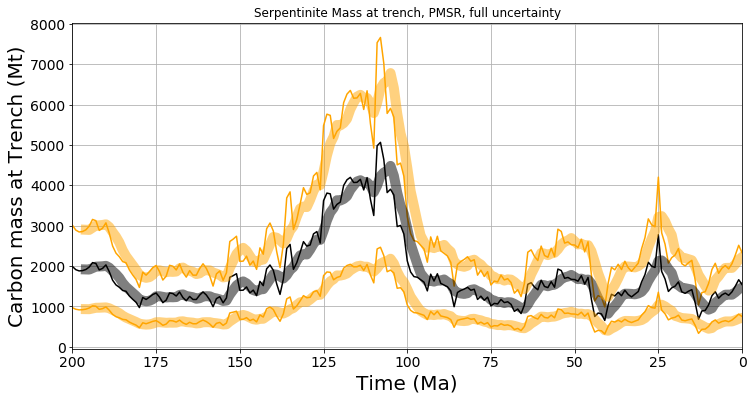

In [56]:
#individual, z2?
plt.figure(figsize=(12,6))

plt.plot(mean, color='k')
plt.plot(mean+std, color='orange')
plt.plot(mean-std, color='orange')

plt.plot(smooth_mean, color='k', lw=10, alpha=0.5)
plt.plot(smooth_mean+smooth_std, color='orange', lw=10, alpha=0.5)
plt.plot(smooth_mean-smooth_std, color='orange', lw=10, alpha=0.5)

plt.xlabel('Time (Ma)', fontsize=20)
plt.ylabel('Carbon mass at Trench (Mt)', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Serpentinite Mass at trench, PMSR, full uncertainty')

plt.xlim(200,0)
plt.grid()